## Importing Libraries
---

In [89]:
!pip install transformers
!pip install TensorFlow

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
pd.set_option("display.max_colwidth", None)

In [12]:
with open('/kaggle/input/chatbots-intent-recognition-dataset/Intent.json') as f:
    data = json.load(f)

In [66]:
df = pd.DataFrame(data['intents'])
df.head(2)

,intent,text,responses,extension,context,entityType,entities
0,Greeting,"[Hi, Hi there, Hola, Hello, Hello there, Hya, Hya there]","[Hi human, please tell me your GeniSys user, Hello human, please tell me your GeniSys user, Hola human, please tell me your GeniSys user]","{'function': '', 'entities': False, 'responses': []}","{'in': '', 'out': 'GreetingUserRequest', 'clear': False}",NA,[]
1,GreetingResponse,"[My user is Adam, This is Adam, I am Adam, It is Adam, My user is Bella, This is Bella, I am Bella, It is Bella]","[Great! Hi <HUMAN>! How can I help?, Good! Hi <HUMAN>, how can I help you?, Cool! Hello <HUMAN>, what can I do for you?, OK! Hola <HUMAN>, how can I help you?, OK! hi <HUMAN>, what can I do for you?]","{'function': 'extensions.gHumans.updateHuman', 'entities': True, 'responses': ['Hi %%HUMAN%%! How can I help?', 'Hi %%HUMAN%%, how can I help you?', 'Hello %%HUMAN%%, what can I do for you?', 'Hola %%HUMAN%%, how can I help you?', 'OK hi %%HUMAN%%, what can I do for you?']}","{'in': 'GreetingUserRequest', 'out': '', 'clear': True}",NA,"[{'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo': 4}, {'entity': 'HUMAN', 'rangeFrom': 2, 'rangeTo': 3}, {'entity': 'HUMAN', 'rangeFrom': 1, 'rangeTo': 2}, {'entity': 'HUMAN', 'rangeFrom': 2, 'rangeTo': 3}, {'entity': 'HUMAN', 'rangeFrom': 3, 'rangeTo': 4}, {'entity': 'HUMAN', 'rangeFrom': 2, 'rangeTo': 3}, {'entity': 'HUMAN', 'rangeFrom': 1, 'rangeTo': 2}, {'entity': 'HUMAN', 'rangeFrom': 2, 'rangeTo': 3}]"


## Data Preprocessing
---

In [14]:
df_patterns = df[['text', 'intent']]
df_responses = df[['responses', 'intent']]
df_patterns.head(2)

,text,intent
0,"[Hi, Hi there, Hola, Hello, Hello there, Hya, Hya there]",Greeting
1,"[My user is Adam, This is Adam, I am Adam, It is Adam, My user is Bella, This is Bella, I am Bella, It is Bella]",GreetingResponse


In [15]:
df_patterns.shape

(22, 2)

In [16]:
df_patterns = df_patterns.explode('text')
df_patterns.head()

,text,intent
0,Hi,Greeting
0,Hi there,Greeting
0,Hola,Greeting
0,Hello,Greeting
0,Hello there,Greeting


In [17]:
df_patterns.describe()

,text,intent
count,143,143
unique,142,22
top,Your real name please?,CourtesyGreetingResponse
freq,2,8


In [18]:
df_patterns.drop_duplicates(inplace= True)

In [19]:
df_patterns.describe()

,text,intent
count,142,142
unique,142,22
top,Hi,CourtesyGreetingResponse
freq,1,8


In [20]:
df_patterns['intent'].value_counts()

intent
CourtesyGreetingResponse    8
GreetingResponse            8
Greeting                    7
NotTalking2U                7
PodBayDoorResponse          7
PodBayDoor                  7
Clever                      7
Shutup                      7
TimeQuery                   7
CurrentHumanQuery           7
CourtesyGreeting            7
SelfAware                   7
Thanks                      6
UnderstandQuery             6
RealNameQuery               6
CourtesyGoodBye             6
WhoAmI                      6
NameQuery                   6
Gossip                      6
Jokes                       6
Swearing                    4
GoodBye                     4
Name: count, dtype: int64

## Data Balancing
---
We will balance the unbalanced classes by randomly duplicating rows from such classes

In [21]:
def balancing_data(df_patterns):
    df_intent = df_patterns['intent']
    max_counts = df_intent.value_counts().max() #max number of examples for a class
    
    new_df = df_patterns.copy()
    for i in df_intent.unique():
        i_count = int(df_intent[df_intent == i].value_counts())
        if i_count < max_counts:
            i_samples = df_patterns[df_intent == i].sample(max_counts - i_count, replace = True, ignore_index = True)
            new_df = pd.concat([new_df, i_samples])
    return new_df

In [90]:
df_patterns = balancing_data(df_patterns)

In [23]:
df_patterns['intent'].value_counts()

intent
Greeting                    8
GreetingResponse            8
PodBayDoorResponse          8
PodBayDoor                  8
Jokes                       8
Gossip                      8
Clever                      8
WhoAmI                      8
CourtesyGoodBye             8
GoodBye                     8
Swearing                    8
Shutup                      8
UnderstandQuery             8
NotTalking2U                8
Thanks                      8
TimeQuery                   8
RealNameQuery               8
NameQuery                   8
CurrentHumanQuery           8
CourtesyGreetingResponse    8
CourtesyGreeting            8
SelfAware                   8
Name: count, dtype: int64

## Data Visualization

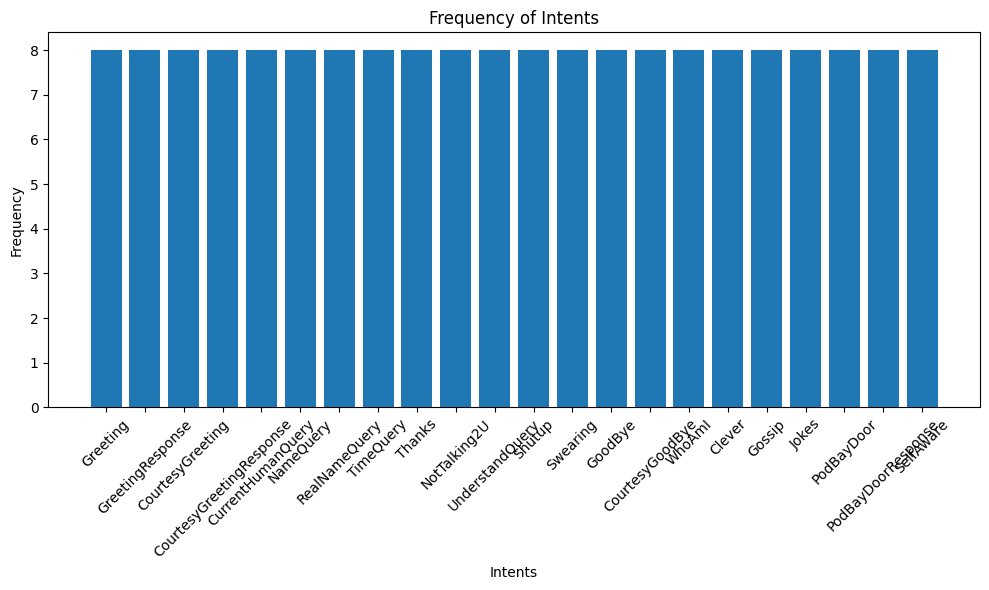

In [78]:
frequency = df_patterns['intent'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(df_patterns['intent'].unique(), frequency)
plt.xlabel('Intents')
plt.ylabel('Frequency')
plt.title('Frequency of Intents')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Display the bar chart
plt.tight_layout()
plt.show()

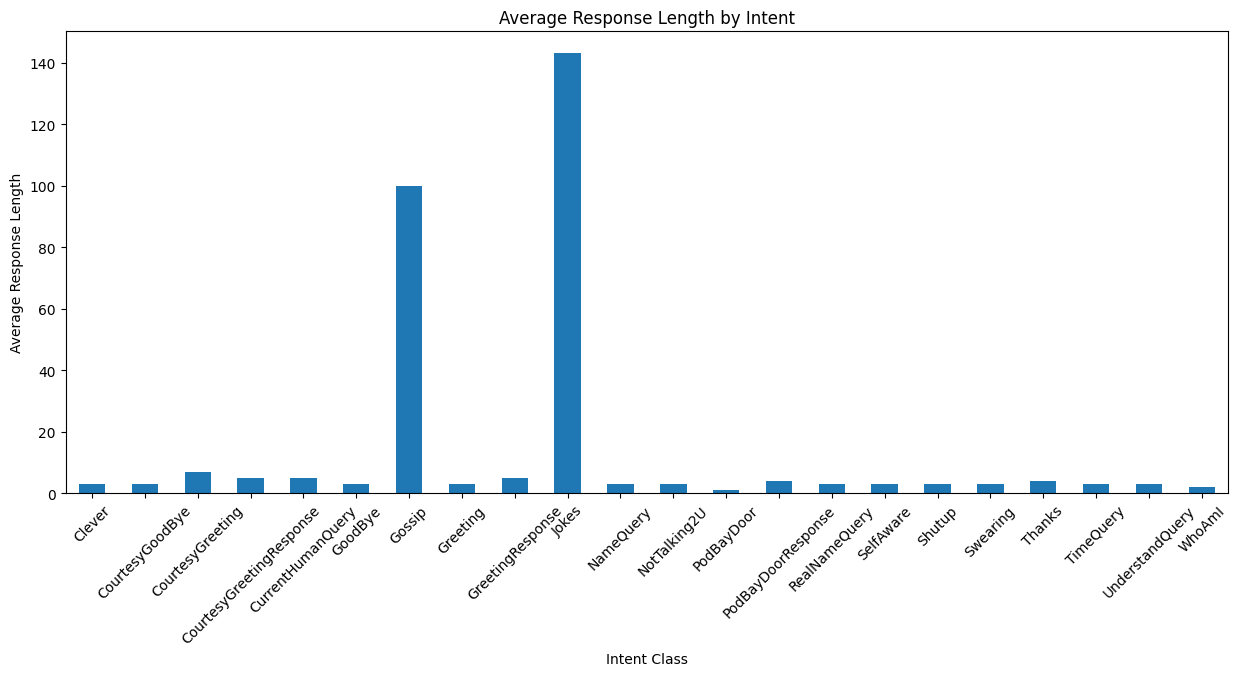

In [87]:
# Calculate the lengths of responses for each intent
intent_response_lengths = df.groupby('intent')['responses'].apply(lambda x: x.str.len().mean())

# Create a bar chart to show the average response length for each intent
plt.figure(figsize=(15, 6))
intent_response_lengths.plot(kind='bar')
plt.title('Average Response Length by Intent')
plt.xlabel('Intent Class')
plt.ylabel('Average Response Length')
plt.xticks(rotation=45)
plt.show()

## Token_ID, Attention_Mask, Labels
---

In [24]:
seq_len = 256
num_samples = len(df_patterns)

Xids = np.zeros((num_samples, seq_len)) #Token ids
Xmask = np.zeros((num_samples, seq_len)) #attention mask

In [25]:
Xids.shape

(176, 256)

In [26]:
Xids

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [27]:
%%time
# we will populate the above zero arrays with actual values for each token
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

for i, phrase in enumerate(df_patterns['text']):
    tokens = tokenizer.encode_plus(phrase, max_length= seq_len, truncation= True, padding= 'max_length', add_special_tokens = True, return_tensors= 'tf')
    
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 5.78 s, sys: 2.14 s, total: 7.92 s
Wall time: 15 s


In [28]:
Xids

array([[ 101., 8790.,  102., ...,    0.,    0.,    0.],
       [ 101., 8790., 1175., ...,    0.,    0.,    0.],
       [ 101., 9800., 1742., ...,    0.,    0.,    0.],
       ...,
       [ 101., 3100., 1128., ...,    0.,    0.,    0.],
       [ 101., 2009., 1209., ...,    0.,    0.,    0.],
       [ 101., 2825., 1128., ...,    0.,    0.,    0.]])

one-hot encoding the labels  
first we will label encode the current values

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [30]:
arr = le.fit_transform(df_patterns['intent'])
arr

array([ 7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4, 10, 10, 10, 10, 10, 10, 14, 14, 14, 14, 14, 14, 19, 19,
       19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 18, 11, 11, 11, 11, 11, 11,
       11, 20, 20, 20, 20, 20, 20, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17,
       17,  5,  5,  5,  5,  1,  1,  1,  1,  1,  1, 21, 21, 21, 21, 21, 21,
        0,  0,  0,  0,  0,  0,  0,  6,  6,  6,  6,  6,  6,  9,  9,  9,  9,
        9,  9, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 15,
       15, 15, 15, 15, 15, 15,  7,  2,  4, 10, 10, 14, 14, 19, 18, 18, 11,
       20, 20, 16, 17, 17, 17, 17,  5,  5,  5,  5,  1,  1, 21, 21,  0,  6,
        6,  9,  9, 12, 13, 15])

In [31]:
le.classes_

array(['Clever', 'CourtesyGoodBye', 'CourtesyGreeting',
       'CourtesyGreetingResponse', 'CurrentHumanQuery', 'GoodBye',
       'Gossip', 'Greeting', 'GreetingResponse', 'Jokes', 'NameQuery',
       'NotTalking2U', 'PodBayDoor', 'PodBayDoorResponse',
       'RealNameQuery', 'SelfAware', 'Shutup', 'Swearing', 'Thanks',
       'TimeQuery', 'UnderstandQuery', 'WhoAmI'], dtype=object)

In [32]:
labels = np.zeros((num_samples, arr.max()+1))
labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
labels[np.arange(num_samples), arr] = 1
labels 

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [34]:
len(labels)

176

## Data Pipeline
---

In [35]:
import tensorflow as tf

In [36]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(22,), dtype=tf.float64, name=None))>

In [37]:
dataset.as_numpy_iterator().next()

(array([ 101., 8790.,  102.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

Tensorflow expects a tuple with 2 inputs only, examples at index 0 and Labels at index 1

In [38]:
def map_function(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

In [39]:
dataset = dataset.map(map_function)

In [40]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(22,), dtype=tf.float64, name=None))>

In [41]:
batch_size = 8

dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder= True)

In [42]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(8, 256), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(8, 256), dtype=tf.float64, name=None)}, TensorSpec(shape=(8, 22), dtype=tf.float64, name=None))>

In [43]:
split = 0.9 

size = int((num_samples / batch_size) * split)

In [44]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

## Training the Tranformer model
---

In [45]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [46]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [47]:
input_ids = tf.keras.layers.Input(shape= (seq_len,), name= 'input_ids', dtype='int32') #input layer for tokens
mask = tf.keras.layers.Input(shape= (seq_len,), name= 'attention_mask', dtype='int32') #input layer for attention masks

embeddings = bert.bert(input_ids, attention_mask= mask)[1]

x = tf.keras.layers.Dense(1024, activation= 'relu')(embeddings)
y = tf.keras.layers.Dense(arr.max()+1, activation= 'softmax', name= 'outputs')(x)

In [48]:
model = tf.keras.Model(inputs= [input_ids, mask], outputs = y)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [50]:
optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [51]:
model.compile(optimizer= optimizer, loss= loss, metrics = [acc])

In [52]:
%%time
history = model.fit(train_ds, validation_data= val_ds, epochs= 10)

Epoch 1/10
19/19 [==============================] - 57s 620ms/step - loss: 3.1760 - accuracy: 0.0395 - val_loss: 2.9932 - val_accuracy: 0.1667
Epoch 2/10
19/19 [==============================] - 8s 422ms/step - loss: 2.8721 - accuracy: 0.1842 - val_loss: 2.6389 - val_accuracy: 0.2500
Epoch 3/10
19/19 [==============================] - 8s 409ms/step - loss: 2.6272 - accuracy: 0.3026 - val_loss: 2.4357 - val_accuracy: 0.2917
Epoch 4/10
19/19 [==============================] - 8s 424ms/step - loss: 2.3864 - accuracy: 0.4605 - val_loss: 2.1058 - val_accuracy: 0.6667
Epoch 5/10
19/19 [==============================] - 8s 416ms/step - loss: 2.1504 - accuracy: 0.5000 - val_loss: 1.9034 - val_accuracy: 0.5417
Epoch 6/10
19/19 [==============================] - 8s 419ms/step - loss: 1.8709 - accuracy: 0.7368 - val_loss: 1.4767 - val_accuracy: 0.8333
Epoch 7/10
19/19 [==============================] - 8s 424ms/step - loss: 1.6010 - accuracy: 0.8553 - val_loss: 1.4231 - val_accuracy: 0.9167
Epoch

## Saving the model
---

In [53]:
model.save('intent_prediction_model.h5')

## Loding the model
---

In [54]:
loaded_model = tf.keras.models.load_model('intent_prediction_model.h5')

In [55]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [56]:
seq_len

256

## Prediction
---

In [57]:
def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length = seq_len,
                                  truncation= True, padding= 'max_length',
                                  add_special_tokens = True,
                                  return_tensors= 'tf')
    return {
        'input_ids' : tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask' : tf.cast(tokens['attention_mask'], tf.float64)
    }

In [58]:
def predict_res(text):
    prep = prep_data(text)
    prob = loaded_model.predict(prep)
    res_dict = {0: 'Clever',
                 1: 'CourtesyGoodBye',
                 2: 'CourtesyGreeting',
                 3: 'CourtesyGreetingResponse',
                 4: 'CurrentHumanQuery',
                 5: 'GoodBye',
                 6: 'Gossip',
                 7: 'Greeting',
                 8: 'GreetingResponse',
                 9: 'Jokes',
                 10: 'NameQuery',
                 11: 'NotTalking2U',
                 12: 'PodBayDoor',
                 13: 'PodBayDoorResponse',
                 14: 'RealNameQuery',
                 15: 'SelfAware',
                 16: 'Shutup',
                 17: 'Swearing',
                 18: 'Thanks',
                 19: 'TimeQuery',
                 20: 'UnderstandQuery',
                 21: 'WhoAmI'}
    return res_dict[np.argmax(prob)]

In [59]:
li = ['Clever', 'CourtesyGoodBye', 'CourtesyGreeting',
       'CourtesyGreetingResponse', 'CurrentHumanQuery', 'GoodBye',
       'Gossip', 'Greeting', 'GreetingResponse', 'Jokes', 'NameQuery',
       'NotTalking2U', 'PodBayDoor', 'PodBayDoorResponse',
       'RealNameQuery', 'SelfAware', 'Shutup', 'Swearing', 'Thanks',
       'TimeQuery', 'UnderstandQuery', 'WhoAmI']

di = {}

for i,j in enumerate(li):
    di.update({i:j})

In [60]:
di

{0: 'Clever',
 1: 'CourtesyGoodBye',
 2: 'CourtesyGreeting',
 3: 'CourtesyGreetingResponse',
 4: 'CurrentHumanQuery',
 5: 'GoodBye',
 6: 'Gossip',
 7: 'Greeting',
 8: 'GreetingResponse',
 9: 'Jokes',
 10: 'NameQuery',
 11: 'NotTalking2U',
 12: 'PodBayDoor',
 13: 'PodBayDoorResponse',
 14: 'RealNameQuery',
 15: 'SelfAware',
 16: 'Shutup',
 17: 'Swearing',
 18: 'Thanks',
 19: 'TimeQuery',
 20: 'UnderstandQuery',
 21: 'WhoAmI'}

In [91]:
while True:
    print(predict_res(input()))

 hi this is nouran


1/1 [==============================] - 0s 70ms/step
GreetingResponse


 what time is it


1/1 [==============================] - 0s 76ms/step
TimeQuery


 no!


1/1 [==============================] - 0s 74ms/step
CourtesyGreetingResponse


 hello


1/1 [==============================] - 0s 74ms/step
Greeting


 bye!


1/1 [==============================] - 0s 74ms/step
CourtesyGoodBye


KeyboardInterrupt: Interrupted by user